# Smart Car Buyer AI Agent

## Overview

This notebook presents an intelligent car-buying assistant using LangGraph and an LLM model. The system assists users in defining their car-buying needs, refines search filters, and retrieves relevant listings, providing a streamlined buying experience.

In [1]:
# Import necessary libraries
from typing import TypedDict, Dict, List, Any
from langgraph.graph import StateGraph, END, START, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
import openai
import asyncio
from importnb import Notebook

import os
from dotenv import load_dotenv

# This import is required only for jupyter notebooks, since they have their own eventloop
import nest_asyncio
nest_asyncio.apply()

with Notebook():
    from scrapers.autotrader import AutotraderInterface, WebsiteInterface


/Users/cflorval/Documents/DiamantAI/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Note: you may need to restart the kernel to use updated packages.
zsh:1: command not found: playwright


In [2]:
# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

# Initialize the language model
GPT = ChatOpenAI(model="gpt-4o-mini")

In [3]:
class State(MessagesState):
    """Represents the state of the car-buying process."""
    user_needs: str
    web_interfaces: List[WebsiteInterface]
    listings: List[Dict[str, str]]
    selected_listing: Dict[str, str]
    additional_info: Dict[str, str]
    next_node: str


In [ ]:
from typing import TypedDict
from enum import Enum
from pydantic import BaseModel
import json

class NextStep(Enum):
    ASK_USER_NEEDS = "ask_user_needs"
    BUILD_FILTERS = "build_filters"

class UserNeeds(BaseModel):
    user_needs: str
    next_step: NextStep

USER_NEEDS_GPT = ChatOpenAI(model="gpt-4o-mini", response_format=UserNeeds)

def ask_user_needs(state: State) -> State:
    """Ask user initial questions to define their needs for the car."""
    messages = state.get("messages", [])    
    if len(messages) == 0:
        system_message = "You are a car buying assistant. Your goal is to help the user find a car that meets their needs. Start by introducing yourself and asking about their requirements, such as intended usage (e.g., commuting, family trips), budget, size preferences, and any specific constraints or features they value. Use their responses to guide them toward the best options."
    else:
        system_message = "Ask the user for any additional information that can help narrow down the search. If he asked any questions before, answer them before asking for more information. When answering, make sure to provide clear and concise information, with relevant examples."
        
    existing_needs = state.get("user_needs", "")
    if existing_needs:
        system_message += f" Here's what we know about the needs of the user so far:\n\n{existing_needs}"

    messages.append(SystemMessage(content=system_message))

    # Get message from the LLM
    response = GPT.invoke(messages)
    print(response.content)
    messages += [response]
    
    # User response
    messages += [HumanMessage(input(response.content))]
    
    summarization_messages = messages.copy()
    summarization_messages += [SystemMessage("Summarize the user's car-buying needs in one clear and concise sentence based on their input and any prior knowledge. Provide the next step, such as asking for more details or answer questions under ask_user_needs or going forward to build_filter.")]
    
    response = json.loads(USER_NEEDS_GPT.invoke(summarization_messages).content)

    print("\nI have summarized your car-buying needs as follows:", response["user_needs"])
    messages += [AIMessage("Summarized user-needs: " + response["user_needs"])]

    print(response)
    
    return {"messages": messages, "next_node": response["next_step"], "user_needs": response["user_needs"]}

/Users/cflorval/Documents/DiamantAI/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490: UserWarning: WARNING! response_format is not default parameter.
                response_format was transferred to model_kwargs.
                Please confirm that response_format is what you intended.
  if await self.run_code(code, result, async_=asy):


In [5]:
def build_filters(state: State) -> State:
    """Build and refine search filters based on user needs."""

    print("Building filters based on user needs...")
    
    for interface in state["web_interfaces"]:
        filters_info = interface.get_filters_info()
        
        # TODO: Check if this website is useful to the user based on the filters
        # If not continue to the next interface
        
        # If the website is useful, use LLM to setup the filters based on user needs
        
        # Define system instructions with filters information
        system_message = SystemMessage(filters_info + "\n\n" + "User needs:\n" + state["user_needs"])

        # Use the LLM to process the user's needs and set the filters
        try:
            result = GPT.invoke([system_message])
            llm_response = result.content.strip()

            # Validate and set the filters for the interface
            interface.set_filters_from_llm_response(llm_response)
            print(f"\nSuccessfully set filters for: {interface.base_url}")
            print(f"Updated URL: {interface.url}")
        except ValueError as e:
            print(f"Failed to set filters for {interface.base_url}: {e}")
        except Exception as e:
            print(f"An error occurred while processing filters for {interface.base_url}: {e}")
    
    return

In [6]:
async def fetch_listings_from_sources(web_interfaces: List[WebsiteInterface]) -> List[Dict[str, str]]:
    """Simulate retrieval of car listings from LaCentrale and mobile.de based on filters.
    
    Args:
        filters (dict): Dictionary containing search filters (e.g., budget, fuel type).
        
    Returns:
        list: A list of dictionaries, each representing a car listing.
    """
    listings = []
    for interface in web_interfaces:
        listings += await interface.crawl()
        
    return listings

In [7]:
from typing import Literal, Optional

class UserResponse(BaseModel):
    action: Literal['select_listing', 'refine_search', 'end_conversation']
    listing_id: Optional[str]

CLASSIFIER_GPT = ChatOpenAI(model="gpt-4o-mini", response_format=UserResponse)

def search_listings(state: State) -> State:
    """Search for cars on LaCentrale and mobile.de based on filters."""
    """Display the first listings for the user to view."""
    """Synchronous wrapper for search_listings."""

    print("Searching for listings based on user needs...")
    state["messages"] += [SystemMessage("Searching for listings based on user needs...")]

    async def _search_listings():
        return await fetch_listings_from_sources(state["web_interfaces"])
    
    listings = asyncio.run(_search_listings())
    state["listings"] = listings
    
    print(f"Successfully fetched {len(listings)} listings from the sources.")
    
    AI_message = ""
    
    # Display the first few listings for the user to view
    AI_message += "Here are recent listings that match your requirements:\n"
    for i, listing in enumerate(state["listings"][:5], 1):
        AI_message += f"{i}.\n"
        for key, value in listing.items():
            formatted_key = key.replace("_", " ").capitalize()
            AI_message += f"   {formatted_key}: {value}\n"
        AI_message += "\n"  # Add an extra line for readability
    
    user_prompt = "Would you like to view more details about a specific listing, or refine your search (Write END to finish this conversation) ?"
    AI_message += user_prompt
    
    print("\033[92m" + AI_message + "\033[0m")
        
    state["messages"].append(AIMessage(AI_message))
    state["messages"].append(HumanMessage(input(user_prompt)))
       
    response = json.loads(CLASSIFIER_GPT.invoke(state["messages"]).content)
    
    print(response)

    if response["action"] == "select_listing":
        state["next_node"] = "fetch_additional_info"
        selected_listing_id = response["listing_id"]
        for i, listing in enumerate(state["listings"][:5], 1):
            if selected_listing_id in listing["id"]:
                state["selected_listing"] = listing
                break
    elif response["action"] == "refine_search":
        state["next_node"] = "ask_user_needs"
    else:
        state["next_node"] = END
        
    return state

In [8]:
def fetch_additional_info(state: State) -> State:
    """Fetch more details about the selected car listing."""
    listing = state["selected_listing"]
    prompt = SystemMessage(
        f"Provide additional information about this car: {listing['title']}, "
        f"including engine specifications, common issues with this model, and market value."
    )
    
    result = GPT.invoke([prompt])
    
    listing["additional_info"] = result.content
    
    print(f"\033[92mHere is additional information about the selected car:\n{listing['additional_info']}\n\033[0m")
    
    user_prompt = "Would you like to view more details about another listing, or refine your search (Write END to finish this conversation) ?"
    state["messages"] += [SystemMessage(user_prompt)]
    state["messages"] += [HumanMessage(input(user_prompt))]
    
    response = json.loads(CLASSIFIER_GPT.invoke(state["messages"]).content)
    
    print(response)

    if response["action"] == "select_listing":
        state["next_node"] = "fetch_additional_info"
        selected_listing_id = response["listing_id"]
        for i, listing in enumerate(state["listings"][:5], 1):
            if selected_listing_id in listing["id"]:
                state["selected_listing"] = listing
                break
    elif response["action"] == "refine_search":
        state["next_node"] = "ask_user_needs"
    else:
        state["next_node"] = END
    
    return state

In [9]:
# Initialize the StateGraph
workflow = StateGraph(State)

# Define the nodes in the graph
workflow.add_node("ask_user_needs", ask_user_needs)
workflow.add_node("build_filters", build_filters)
workflow.add_node("search_listings", search_listings)
workflow.add_node("fetch_additional_info", fetch_additional_info)

# Define edges
workflow.add_conditional_edges("ask_user_needs", lambda state: state["next_node"], ["build_filters", "ask_user_needs"])
workflow.add_edge("build_filters", "search_listings")
workflow.add_conditional_edges("search_listings", lambda state: state["next_node"], ["fetch_additional_info", "ask_user_needs", END])

# Set the entry and exit points
workflow.set_entry_point("ask_user_needs")
workflow.add_conditional_edges("fetch_additional_info", lambda state: state["next_node"], ["ask_user_needs", "fetch_additional_info", END])


# Compile the workflow
app = workflow.compile()

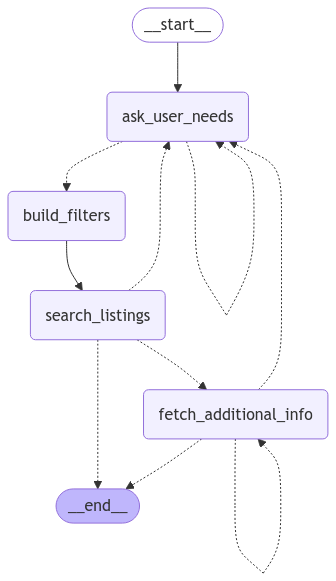

In [10]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [11]:
# Verify initial setup and function invocation
def run_car_buyer_agent():
    """Run the car-buying assistant with LangGraph."""
        
    messages = []
    
    initial_state = State(
        user_needs={}, 
        web_interfaces=[AutotraderInterface()], 
        listings=[],
        selected_listing={}, 
        additional_info={},
        next_node="",
        messages=messages
    )
    result = app.invoke(initial_state)
    return result

# Execute the agent
car_buyer_result = run_car_buyer_agent()

# Print result for debugging purposes
print("Car Buyer Result:", car_buyer_result)

Hello! I'm your car buying assistant, here to help you find the perfect vehicle that suits your needs. To get started, could you please share a bit about what you’re looking for? 

Here are some questions to consider:
- What will you primarily use the car for (e.g., commuting, family trips, off-roading)?
- What’s your budget for the purchase?
- Do you have any size preferences (e.g., sedan, SUV, truck)?
- Are there any specific features or constraints that are important to you (e.g., fuel efficiency, safety ratings, technology features)?

Feel free to share any other details that might help narrow down the options!

I have summarized your car-buying needs as follows: The user is looking for an affordable off-road SUV priced under $60,000 without any additional requirements.
{'user_needs': 'The user is looking for an affordable off-road SUV priced under $60,000 without any additional requirements.', 'next_step': 'build_filters'}
Building filters based on user needs...

Successfully set 

In [12]:
# Display summary of the final recommendation
if "selected_listing" in car_buyer_result:
    listing = car_buyer_result["selected_listing"]
    print(f"\nFinal Recommendation:\n{listing['title']} - {listing['price']} - {listing['mileage']} km")
    print("Additional Information:")
    for key, value in car_buyer_result["additional_info"].items():
        print(f"{key}: {value}")
else:
    print("No car listing selected.")


Final Recommendation:
Used 2023 Toyota 4Runner TRD Pro - 57,481 - 16,748 miles km
Additional Information:
